In [1]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../ipa/src/')
import preprocessing_utils as pre
import localization_utils as loc
import detection_utils as det
import nd2
import correction_utils as cor
import stackview
from glob import glob
from tqdm import tqdm
import seaborn as sns

# Open the image

In [258]:
path="/tungstenfs/scratch/ggiorget/nessim/microscopy_data/20240425/beads/ND_Acquisition/20240425_B2_100ms_7%laser_nd009.nd2"
im = nd2.imread(path)
met = nd2.ND2File(path)
print(im.shape)
im=im[:,1:3,:,:]
print(im.shape)
stackview.slice(im[:,1,...], continuous_update=True)

(21, 4, 976, 976)
(21, 2, 976, 976)


/scratch/ubermatt/ipykernel_31039/2617998051.py:3: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  met = nd2.ND2File(path)


In [259]:
df = pd.DataFrame(met.events())
df['dt'] = df['Time [s]'].diff()
df.dt.mean()


0.6008175537109375

# Detect the beads

In [350]:
im_c1 = im[:, 0, ...]
im_c2 = im[:, 1, ...]

In [357]:
n_detections=[]

for t in np.arange(0.1,0.9,0.01):
    n_detections.append(len(pre.get_loc(im=im_c1,frame = im_c1.shape[0]//2,thresh=t,mins=1.974,maxs=3)))
    #h = pre.compute_h_param(im=im_c1,frame = im_c1.shape[0]//2,thresh=0.5)
    #h2 = pre.compute_h_param(im=im_c2,frame = im_c2.shape[0]//2,thresh=0.5)
#print(h,h2)


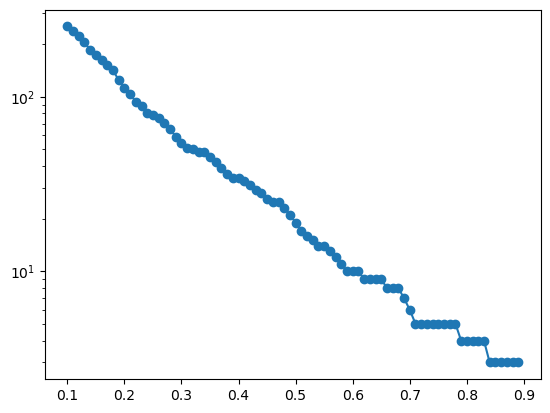

In [359]:
plt.plot(np.arange(0.1,0.9,0.01),n_detections,'-o')
plt.yscale("log")

In [363]:
n_detections[0]*1/np.exp(1)

92.70561917520347

In [ ]:
h = pre.compute_h_param(im=im_c1,frame = im_c1.shape[0]//2,thresh=0.2)
h2 = pre.compute_h_param(im=im_c2,frame = im_c2.shape[0]//2,thresh=0.2)
#print(h,h2)

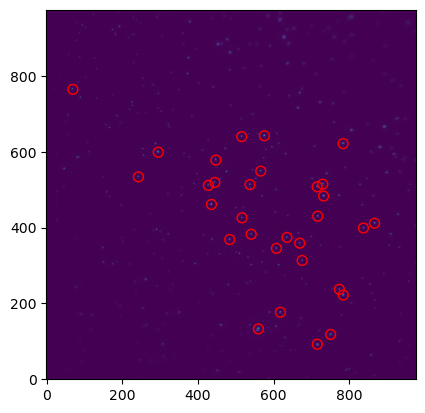

In [327]:
#d = pre.get_loc(im=im_c1,frame = im_c1.shape[0]//2,mins = 0. ,maxs = 2.0 ,thresh = 0.1)
#plt.imshow(im_c1[10,...],origin='lower')
#plt.scatter(d.x,d.y,edgecolors='r',facecolors='none',s=50)

In [325]:
l = []
for i in d.iloc:
    l.append(im_c1[10,int(i.y),int(i.x)])

In [326]:
l

[34034,
 24002,
 20782,
 25373,
 22254,
 13415,
 23618,
 17993,
 21347,
 19831,
 11394,
 19312,
 16952,
 15599,
 16491,
 20439,
 17766,
 16993,
 11666,
 8503,
 8759,
 16967,
 10814,
 12449,
 13513,
 15840,
 13452,
 11070,
 14001,
 14009,
 14529]

(array([3., 7., 5., 6., 4., 3., 2., 0., 0., 1.]),
 array([ 8503. , 11056.1, 13609.2, 16162.3, 18715.4, 21268.5, 23821.6,
        26374.7, 28927.8, 31480.9, 34034. ]),
 <BarContainer object of 10 artists>)

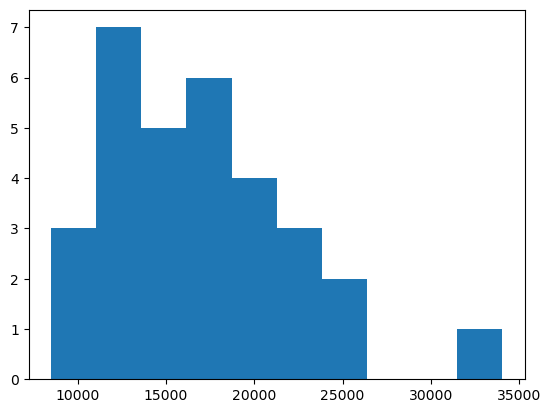

In [318]:
plt.hist(l)

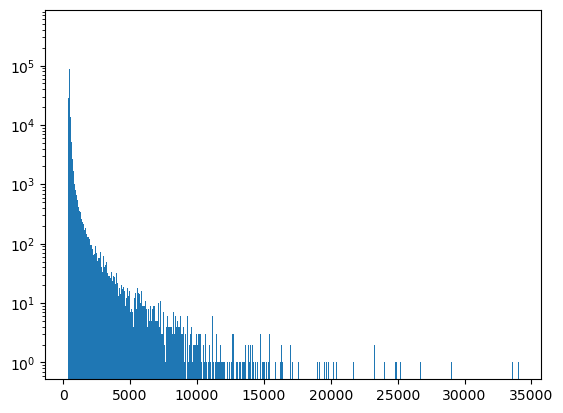

In [308]:
plt.hist(im_c1[im_c1.shape[0]//2].flatten(),bins=1000)
#plt.xscale("log")
plt.yscale("log")
plt.show()

In [172]:
print(h2)

19.606475332711813


/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/tungstenfs/scratch/ggiorget/mattia/miniconda3/envs/Image_Analysis/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [329]:
im_c1 = np.expand_dims(im_c1, axis=0)
im_c2 = np.expand_dims(im_c2, axis=0)

In [330]:
detections = det.hmax_3D(raw_im= im_c1,frame=0,sd=h,n = 1,thresh = 0.5,threads = 20)
detections_temp = det.hmax_3D(raw_im= im_c2,frame=0,sd=h2,n = 1,thresh = 0.5,threads = 20)

In [331]:
detections['channel'] = 1
detections_temp['channel'] = 2

detections_comb = pd.concat([detections, detections_temp])

In [332]:
detections_comb

,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel
0,317.766776,173.213191,8.671524,0.028010,0.028857,0.034450,0,1
1,566.315520,548.607293,10.228331,0.032676,0.030869,0.042988,0,1
2,680.300529,831.867269,11.066836,0.032814,0.032307,0.038426,0,1
3,708.222770,422.079872,10.377581,0.031563,0.031484,0.041224,0,1
4,288.939964,620.605458,10.099374,0.030440,0.029604,0.033908,0,1
...,...,...,...,...,...,...,...,...
143,426.875453,511.249036,10.187233,0.025620,0.025525,0.031084,0,2
144,451.617577,21.987039,8.261053,0.052815,0.040090,0.047119,0,2
145,484.568111,367.581502,9.205031,0.048055,0.038010,0.044846,0,2
146,166.796411,662.915306,9.851897,0.034541,0.035121,0.038676,0,2


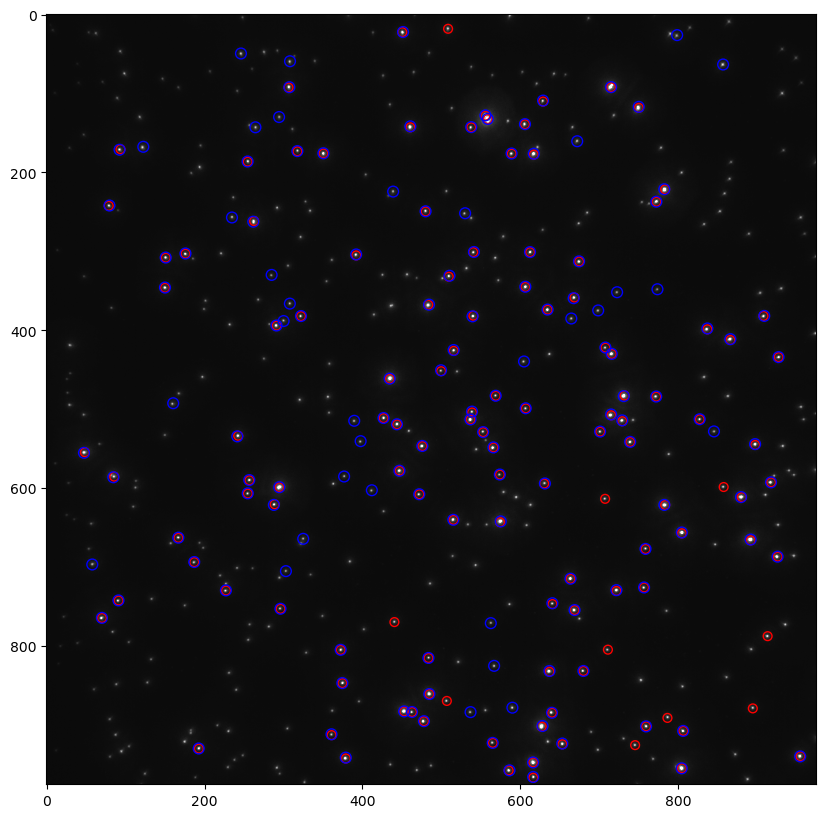

In [333]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(im_c1[0, :, ...],axis=0), cmap='gray', vmin=0, vmax=10000)
plt.scatter(detections_comb[detections_comb.channel == 1]['x'],detections_comb[detections_comb.channel == 1]['y'], edgecolors='r',facecolors='none' ,s=40)
plt.scatter(detections_comb[detections_comb.channel == 2]['x'],detections_comb[detections_comb.channel == 2]['y'], edgecolors='blue',facecolors='none' ,s=60)

# Matching

In [334]:
detections_comb['x'] = detections_comb['x']*met.voxel_size()[0]
detections_comb['y'] = detections_comb['y']*met.voxel_size()[1]
detections_comb['z'] = detections_comb['z']*met.voxel_size()[2]

In [335]:
detections_f = detections_comb#.query('x > 32 and x < 84 and y > 32 and y < 84')

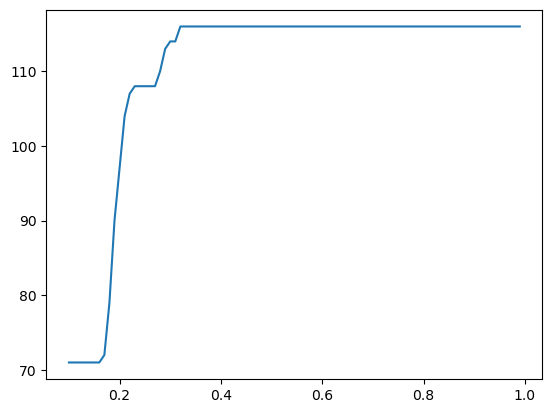

In [336]:
cutoff=np.arange(0.1,1,0.01)
n_matched=[]
for c in cutoff:
    matched = cor.assign_closest(detections_f[detections_f.channel ==1],detections_f[detections_f.channel ==2],c)
    n_matched.append(len(matched))
plt.plot(cutoff,n_matched)

In [337]:
matched = cor.assign_closest(detections_f[detections_f.channel ==1],detections_f[detections_f.channel ==2],0.2)

In [338]:
len(matched)

97

In [339]:
detections_1 = detections_f[detections_f.channel == 1].copy()
detections_2 = detections_f[detections_f.channel == 2].copy()

In [340]:
detections_1

,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel
0,41.309681,22.517715,1.734305,0.028010,0.028857,0.034450,0,1
1,73.621018,71.318948,2.045666,0.032676,0.030869,0.042988,0,1
2,88.439069,108.142745,2.213367,0.032814,0.032307,0.038426,0,1
3,92.068960,54.870383,2.075516,0.031563,0.031484,0.041224,0,1
4,37.562195,80.678709,2.019875,0.030440,0.029604,0.033908,0,1
...,...,...,...,...,...,...,...,...
121,115.999224,86.627825,2.108350,0.046561,0.047530,0.049867,0,1
122,21.698102,86.201609,1.999414,0.032575,0.033147,0.035988,0,1
123,10.215677,31.499033,1.861103,0.031804,0.033909,0.045226,0,1
124,80.167572,125.735649,2.295054,0.034432,0.035941,0.042595,0,1


In [341]:
for i in matched:
    detections_1.loc[i[0],'dx'] = i[2]
    detections_1.loc[i[0],'dy'] = i[3]
    detections_1.loc[i[0],'dz'] = i[4]

In [342]:
detections_1.dropna(inplace=True, axis=0)

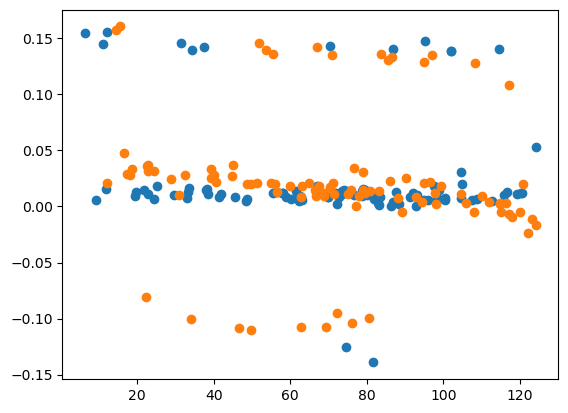

In [343]:
dx=detections_1["dx"].values
x=detections_1["x"]
plt.scatter(detections_1["x"],detections_1["dx"].values)
plt.scatter(detections_1["y"],detections_1["dy"].values)
#plt.scatter(detections_1["z"],detections_1["dz"].values)

In [344]:
detections_heat = detections_1[['x','y','dx']]
detections_heat = detections_heat.pivot(index='x',columns='y',values='dx')
detections_heat.fillna(0,inplace=True)

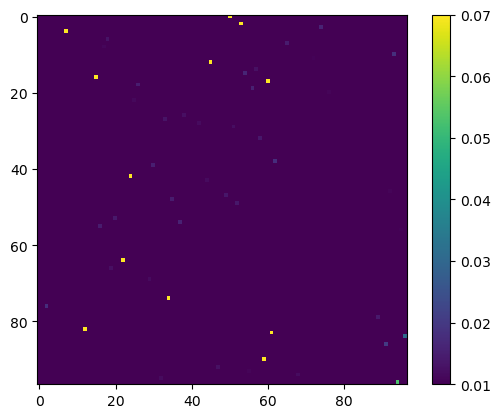

In [345]:
plt.imshow(detections_heat,vmin=0.01,vmax=0.07,interpolation='none')
plt.colorbar()

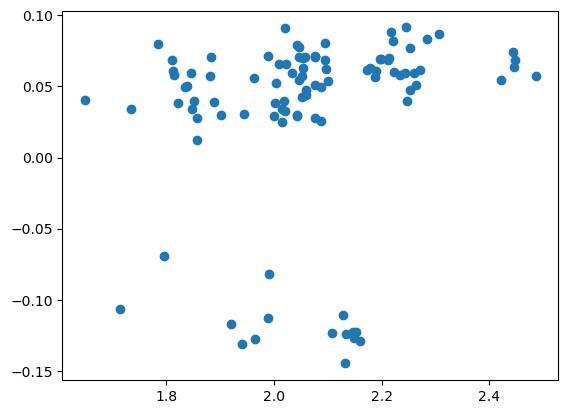

In [346]:
plt.scatter(detections_1["z"],detections_1["dz"].values)

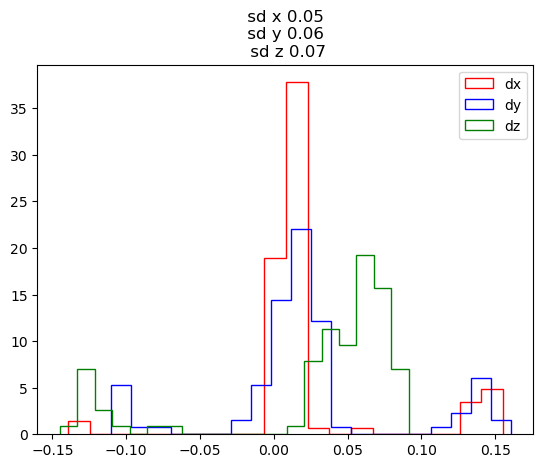

In [347]:
plt.hist(detections_1["dx"].values,histtype='step',color='r',bins=20,density=True,label='dx')
plt.hist(detections_1["dy"].values,histtype='step',color='b',bins=20,density=True,label='dy')
plt.hist(detections_1["dz"].values,histtype='step',color='g',bins=20,density=True,label='dz')
plt.title(f' sd x {np.std(detections_1["dx"].values):,.2f} \n sd y {np.std(detections_1["dy"].values):,.2f} \n sd z {np.std(detections_1["dz"].values):,.2f}')
plt.legend()
plt.show()

In [348]:
d=np.sqrt(detections_1["dx"].values**2+detections_1["dy"].values**2+detections_1["dz"].values**2)
print(np.std(d))

0.05555091773066076


# Multiple movies

In [19]:
df_comb = []
for path in tqdm(glob('../runs/20240425_beads/*.csv')):
    df_temp = pd.read_csv(path)
    df_temp['run'] = path.split('/')[-1].split('.')[0]
    df_comb.append(df_temp)

df_comb = pd.concat(df_comb)

100%|██████████| 10/10 [00:00<00:00, 495.96it/s]


In [20]:
df_comb

,Unnamed: 0,x,y,z,sd_fit_x,sd_fit_y,sd_fit_z,frame,channel,dx,dy,dz,run
0,0,39.544718,52.094789,2.004156,0.030562,0.029426,0.034127,0.0,1.0,0.010890,0.026147,0.056132,detections_20240425_B2_100ms_7%laser_nd004
1,1,15.709265,95.076455,2.232823,0.027845,0.028715,0.035265,0.0,1.0,0.008679,0.015640,0.047716,detections_20240425_B2_100ms_7%laser_nd004
2,3,26.558451,106.984689,2.248472,0.033709,0.032871,0.039257,0.0,1.0,0.009411,0.014154,0.039563,detections_20240425_B2_100ms_7%laser_nd004
3,4,75.130859,16.094377,2.012489,0.037168,0.036731,0.044117,0.0,1.0,0.003968,0.035756,0.074003,detections_20240425_B2_100ms_7%laser_nd004
4,5,16.164762,26.907545,1.804013,0.035738,0.033696,0.043228,0.0,1.0,0.011199,0.040937,0.030470,detections_20240425_B2_100ms_7%laser_nd004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
192,233,18.832298,66.030206,2.028297,0.029848,0.030020,0.034913,0.0,1.0,0.021041,0.056157,0.069620,detections_20240425_B2_100ms_7%laser_nd007
193,234,53.312095,101.495232,2.195866,0.032173,0.031168,0.035857,0.0,1.0,0.021602,-0.013785,0.095108,detections_20240425_B2_100ms_7%laser_nd007
194,236,13.749126,17.578983,1.888359,0.032550,0.033959,0.058479,0.0,1.0,0.023086,0.019888,0.023919,detections_20240425_B2_100ms_7%laser_nd007
195,238,54.932716,78.453836,2.227756,0.033974,0.033949,0.042446,0.0,1.0,0.018835,0.015273,0.047976,detections_20240425_B2_100ms_7%laser_nd007


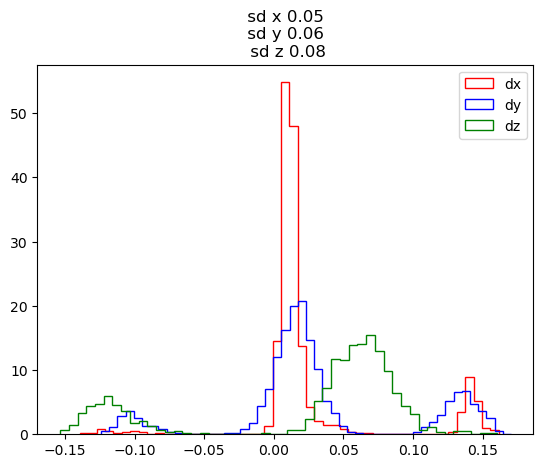

In [23]:
plt.hist(df_comb["dx"],histtype='step',color='r',bins=50,density=True,label='dx')
plt.hist(df_comb["dy"],histtype='step',color='b',bins=50,density=True,label='dy')
plt.hist(df_comb["dz"],histtype='step',color='g',bins=50,density=True,label='dz')
plt.title(f' sd x {np.std(df_comb["dx"].values):,.2f} \n sd y {np.std(df_comb["dy"].values):,.2f} \n sd z {np.std(df_comb["dz"].values):,.2f}')
plt.legend()
plt.show()

Text(0.5, 1.0, 'dx colored by movie')

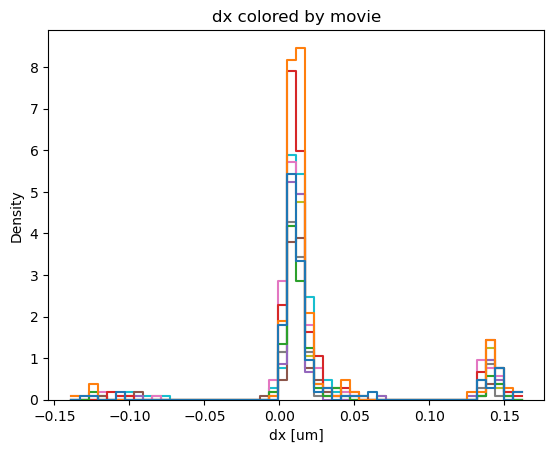

In [34]:

sns.histplot(data= df_comb,x='dx',element='step',fill=False,hue='run',bins=50,stat='density',label='dx',legend=False)
plt.xlabel('dx [um]')
plt.title('dx colored by movie')

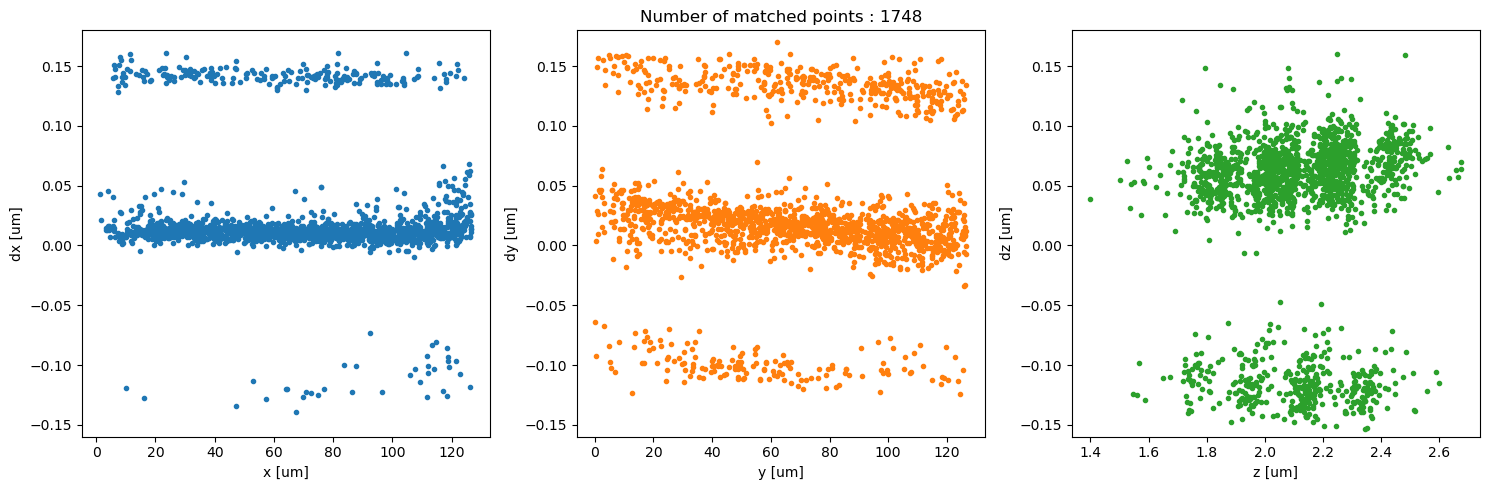

In [100]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(df_comb['x'],df_comb['dx'],'.')
ax[0].set_xlabel('x [um]')
ax[0].set_ylabel('dx [um]')

ax[1].plot(df_comb['y'],df_comb['dy'],'.',color='tab:orange')
ax[1].set_xlabel('y [um]')
ax[1].set_ylabel('dy [um]')
ax[2].plot(df_comb['z'],df_comb['dz'],'.',color='tab:green')
ax[2].set_xlabel('z [um]')
ax[2].set_ylabel('dz [um]')

ax[1].set_title(f'Number of matched points : {len(df_comb)}')

for a in ax:
    a.set_ylim(-0.16,0.18)

plt.tight_layout()
plt.show()

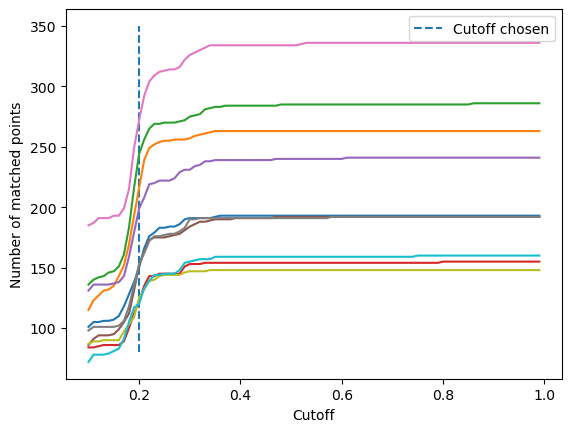

In [88]:
n_match = np.zeros((90,len(glob('../runs/20240425_beads/n_matched*'))))

# n_match.shape
for l,path in enumerate(glob('../runs/20240425_beads/n_matched*')):
    n_match[:,l] = np.load(path)

plt.vlines(0.2,80,350,linestyles='dashed',label='Cutoff chosen')
plt.legend()
for i in n_match.T:
    plt.plot(np.arange(0.1,1,0.01),i)


plt.ylabel('Number of matched points')
plt.xlabel('Cutoff')
plt.show()

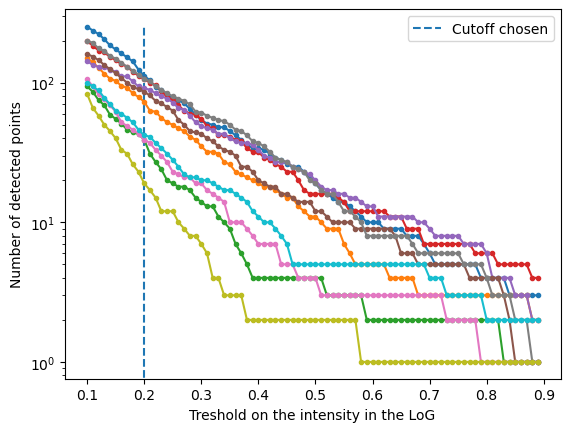

In [98]:
n_detect = np.zeros((80,len(glob('../runs/20240425_beads/n_detections*'))))

# n_match.shape
for l,path in enumerate(glob('../runs/20240425_beads/n_detections*')):
    n_detect[:,l] = np.load(path)

plt.vlines(0.2,0,255,label='Cutoff chosen',linestyles='dashed')
plt.legend()
for i in n_detect.T:
    plt.plot(np.arange(0.1,0.9,0.01),i,'.-')


plt.ylabel('Number of detected points')
plt.yscale('log')

plt.xlabel('Treshold on the intensity in the LoG')
plt.show()